In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

#Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement

station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#inspect measurement
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
#inspect station
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

## Design a query to retrieve the last 12 months of precipitation data and plot the results

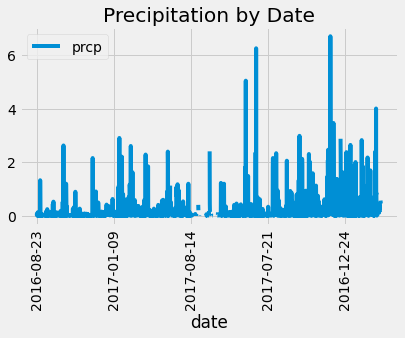

In [28]:
# Calculate the date 1 year ago from the last data point in the database
session.query(measurement.date, measurement.prcp).order_by(measurement.date.desc()).first()
#last date in database is 2017-08-23
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago).all()
#results

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(results, columns=['date', 'prcp'])
prcp_df.set_index('date', inplace=True)
#prcp_df.head(10)

# Sort the dataframe by date
        ##My dataframe is already sorted by date (ascending to most recent date)
    #prcp_df = prcp_df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title="Precipitation by Date")
plt.tight_layout()
plt.xticks(rotation="vertical")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
#I wanted to make the mean and median more clear.
mean = round(prcp_df["prcp"].mean(),2)
print(f"The mean precipitation is {mean}.")

median = prcp_df["prcp"].median()
print(f"The median precipitation is {median}.")

The mean precipitation is 0.18.
The median precipitation is 0.02.


In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(station.station).count()

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?

# List the stations and the counts in descending order.
session.query(measurement.station, func.count(measurement.prcp)).group_by(measurement.station).\
    order_by(func.count(measurement.prcp).desc()).all()


[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [26]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#TOBS data for most active station (USC00519281)
#session.query(measurement.station, measurement.tobs).\
    #filter(measurement.station == 'USC00519281').all()

#lowest_temp
lowest= session.query(measurement.station, measurement.tobs).\
    filter(measurement.station == 'USC00519281').order_by(measurement.tobs).first()
display(lowest)

#highest_temp
highest = session.query(measurement.station, measurement.tobs).\
    filter(measurement.station == 'USC00519281').order_by((measurement.tobs).desc()).first()
display(highest)

#average_temp  ASK ABEL
average = session.query(measurement.station, func.avg(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').all()
display(average)


('USC00519281', 54.0)

('USC00519281', 85.0)

[('USC00519281', 71.66378066378067)]

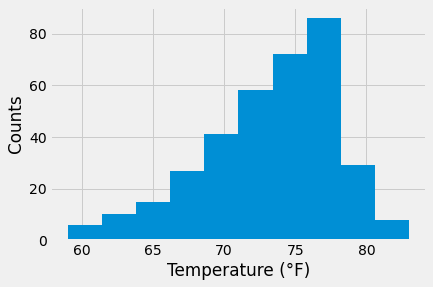

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#find most active temperature station
session.query(measurement.station, func.count(measurement.tobs)).group_by(measurement.station).\
    order_by(func.count(measurement.tobs).desc()).all()
#MOST ACTIVE STATION IS 'USC00519281'

#last 12 months of temp data
results2 = session.query(measurement.date, measurement.tobs).\
    filter(measurement.date >= one_year_ago).\
    filter(measurement.station =='USC00519281').all()

#put into dataframe
tobs_df = pd.DataFrame(results2, columns=['date', 'tobs'])
tobs_df.set_index('date', inplace=True)
#tobs_df.head(10)

#plot histogram
temperatures = tobs_df['tobs']
plt.hist(temperatures)
plt.xlabel('Temperature (°F)')
plt.ylabel('Counts')
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
